In [5]:
from mmdet3d.apis import init_model, inference_detector

config_file = 'mmdetection3d/configs/pointpillars/pointpillars_hv_secfpn_8xb6-160e_kitti-3d-car.py'
checkpoint_file = 'pre-trained/hv_pointpillars_secfpn_6x8_160e_kitti-3d-car_20220331_134606-d42d15ed.pth'
model = init_model(config_file, checkpoint_file, device='cpu')
inference_detector(model, 'mmdetection3d/demo/data/kitti/000008.bin')

Loads checkpoint by local backend from path: hv_pointpillars_secfpn_6x8_160e_kitti-3d-car_20220331_134606-d42d15ed.pth


(<Det3DDataSample(
 
     META INFORMATION
     lidar_path: 'mmdetection3d/demo/data/kitti/000008.bin'
     pcd_trans: array([0., 0., 0.])
     pcd_rotation_angle: 0.0
     axis_align_matrix: array([[1., 0., 0., 0.],
                [0., 1., 0., 0.],
                [0., 0., 1., 0.],
                [0., 0., 0., 1.]])
     pcd_horizontal_flip: False
     box_type_3d: <class 'mmdet3d.structures.bbox_3d.lidar_box3d.LiDARInstance3DBoxes'>
     pcd_vertical_flip: False
     box_mode_3d: <Box3DMode.LIDAR: 0>
     pcd_scale_factor: 1.0
     pcd_rotation: tensor([[1., 0., 0.],
                 [-0., 1., 0.],
                 [0., 0., 1.]])
     transformation_3d_flow: ['R', 'S', 'T']
     flip: False
 
     DATA FIELDS
     pred_instances_3d: <InstanceData(
         
             META INFORMATION
         
             DATA FIELDS
             bboxes_3d: LiDARInstance3DBoxes(
                     tensor([[ 14.7584,  -1.0538,  -1.5590,   3.7563,   1.6060,   1.5587,  -0.3131],
                 

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from bagpy import bagreader
from rosbags.image import message_to_cvimage
from collections import defaultdict
import cv2 as cv
import open3d as o3d
import detectron2
import sensor_msgs.point_cloud2 as pc2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import pyrealsense2 as rs2
if (not hasattr(rs2, 'intrinsics')):
    import pyrealsense2.pyrealsense2 as rs2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
path = os.path.join("/home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced", "defaced_2021-03-25-14-52-33.bag")
bag = bagreader(path).reader

[INFO]  Data folder /home/pbr-student/personal/thesis/crowdbot/rosbags_25_03_shared_control-rgbd_defaced/defaced_2021-03-25-14-52-33 already exists. Not creating.


In [3]:
def msgs(bag):
    """For extracting msgs from Rosbag reader

    Returns:
        Dict[str, List]: list of messages and sequences of each kind
    """
    topic_list = [
        "/camera_left/color/image_raw",
        "/camera_left/aligned_depth_to_color/image_raw",
        "/camera_left/depth/color/points",
        "/camera_left/aligned_depth_to_color/camera_info",
        "/detected_persons/yolo"
    ]
    image_msgs = []
    depth_msgs = []
    depth_pts_msgs = []
    pers_msgs = []
    ci_msgs = []

    counter1 = 100
    counter2 = 100
    counter3 = 100
    counter4 = 100
    counter5 = 100

    for topic, msg, t in bag.read_messages(topics=topic_list):
        
        if counter1 > 0 or counter2 > 0 or counter3 > 0 or counter4 > 0 or counter5>0:
            if topic == "/camera_left/color/image_raw":
                image_msgs.append(msg)
                counter1 -= 1

            if topic == "/camera_left/aligned_depth_to_color/image_raw":
                depth_msgs.append(msg)
                counter2 -= 1

            if topic == "/camera_left/depth/color/points":
                depth_pts_msgs.append(msg)
                counter3 -= 1

            if topic == "/camera_left/aligned_depth_to_color/camera_info":
                ci_msgs.append(msg)
                counter4 -= 1

            if topic =="/detected_persons/yolo":
                pers_msgs.append(msg)
                counter5 -=1
        else:
                break


    bag.close()

    data_params = {
        "image_msgs": image_msgs,
        "depth_msgs": depth_msgs,
        "depth_pts_msgs": depth_pts_msgs,
        "pers_msgs": pers_msgs,
        "ci_msgs": ci_msgs,
    }

    return data_params
data_params = msgs(bag)

header: 
  seq: 178
  stamp: 
    secs: 1616680352
    nsecs: 712948560
  frame_id: "camera_left_color_optical_frame"
height: 480
width: 640
encoding: "rgb8"
is_bigendian: 0
step: 1920
data: [4, 6, 24, 4, 6, 24, 5, 4, 28, 4, 3, 27, 5, 1, 31, 6, 2, 32, 5, 4, 28, 5, 4, 28, 4, 6, 29, 4, 6, 29, 4, 6, 29, 4, 6, 29, 3, 6, 26, 1, 4, 24, 2, 6, 20, 2, 6, 20, 4, 5, 20, 5, 6, 21, 6, 5, 20, 6, 5, 20, 6, 5, 20, 4, 4, 18, 6, 2, 23, 7, 3, 24, 8, 4, 25, 7, 3, 24, 7, 6, 21, 8, 7, 22, 7, 6, 21, 7, 6, 21, 7, 6, 21, 7, 6, 21, 7, 6, 21, 6, 5, 20, 8, 8, 14, 11, 10, 16, 11, 10, 16, 10, 9, 15, 8, 7, 22, 7, 6, 21, 4, 4, 21, 5, 5, 22, 6, 4, 25, 6, 4, 25, 9, 4, 28, 9, 4, 28, 6, 3, 27, 6, 3, 27, 6, 3, 27, 7, 4, 28, 7, 4, 28, 8, 5, 29, 9, 6, 30, 8, 5, 29, 5, 4, 28, 5, 4, 28, 4, 3, 27, 5, 4, 28, 5, 4, 28, 5, 4, 28, 5, 4, 28, 5, 4, 28, 5, 4, 28, 4, 3, 27, 6, 8, 22, 5, 6, 21, 5, 6, 21, 7, 9, 23, 8, 6, 24, 8, 6, 24, 8, 4, 25, 8, 4, 25, 7, 6, 21, 7, 6, 21, 9, 7, 19, 8, 6, 18, 8, 6, 18, 8, 6, 18, 11, 7, 19, 12, 8, 20, 1

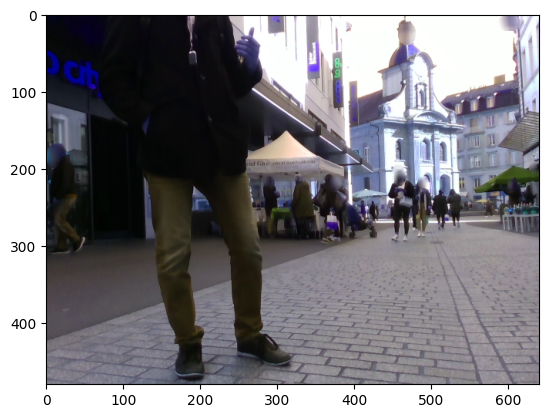

In [12]:
tmp_msg = data_params["image_msgs"][0]
print(tmp_msg)
img = message_to_cvimage(tmp_msg)
plt.imshow(img)


header: 
  seq: 178
  stamp: 
    secs: 1616680362
    nsecs: 700109312
  frame_id: "camera_left_color_optical_frame"
height: 480
width: 640
encoding: "16UC1"
is_bigendian: 0
step: 1280
data: [131, 26, 131, 26, 27, 27, 27, 27, 106, 27, 106, 27, 184, 28, 184, 28, 17, 29, 17, 29, 201, 29, 201, 29, 138, 30, 138, 30, 190, 31, 190, 31, 190, 31, 190, 31, 43, 32, 43, 32, 190, 31, 190, 31, 190, 31, 190, 31, 85, 31, 85, 31, 138, 30, 138, 30, 201, 29, 201, 29, 201, 29, 201, 29, 108, 29, 108, 29, 184, 28, 184, 28, 98, 28, 98, 28, 13, 28, 13, 28, 106, 27, 106, 27, 27, 27, 27, 27, 131, 26, 131, 26, 57, 26, 57, 26, 57, 26, 57, 26, 57, 26, 57, 26, 241, 25, 241, 25, 241, 25, 241, 25, 170, 25, 170, 25, 170, 25, 170, 25, 170, 25, 170, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 101, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 131, 26, 131, 26, 57, 26, 57, 26, 2

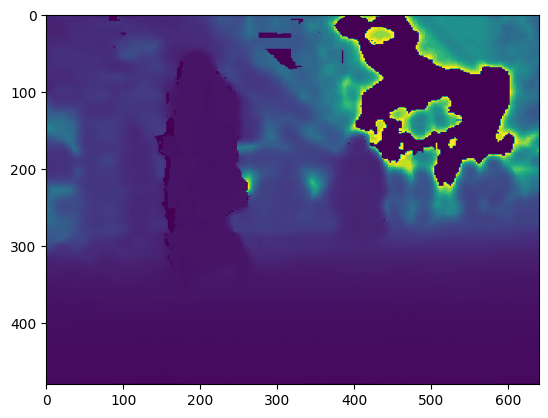

In [15]:
depth_msg = data_params["depth_msgs"][81]
print(depth_msg)
img2 = message_to_cvimage(depth_msg)
plt.imshow(img2)